In [32]:
import sys, os
sys.path.insert(0, os.path.abspath("../.."))
import matplotlib.pyplot as plt
import pandas as pd

import pygimli as pg
import numpy as np


from invlib import set_style
fs = 5.5
set_style(fs, style="seaborn-dark")

In [33]:
day = "2014-08-19 00:00:00"
sch5000 = pd.read_csv("./SCH_5000.csv", skiprows=4, parse_dates=True)
sch5198 = pd.read_csv("./SCH_5198.csv", skiprows=4, parse_dates=True)
sch5000 = sch5000.set_index("Time").T[day].rename("sch5000")
sch5198 = sch5198.set_index("Time").T[day].rename("sch5198")
zusammen = pd.concat([sch5000, sch5198], axis=1, sort=True)

In [49]:
mesh = pg.load("paraDomain.bms")
joint = np.load("joint_inversion.npz")

bl1 = {
    "name": "SCH_5198",
    "depth": 0.15,
    "pos": 10,
    "temp": np.column_stack((sch5198, np.asarray(sch5198.index, dtype="float"))),
    "templim": (-0.5, 3.5),
    "alt": 2.0
}

bl2 = {
    "name": "SCH_5000",
    "depth": 0.65,
    "pos": 26,
    "temp": np.column_stack((sch5000, np.asarray(sch5000.index, dtype="float"))),
    "templim": (-0.2, 0.7),
    "alt": 2.2
}

def get(quant, bl):
    quant = joint[quant]
    y = np.linspace(-12, -bl["depth"])
    profile = pg.interpolate(mesh, quant, x=np.ones_like(y) * bl["pos"], y=y)
    y += bl["depth"]
    return (profile, -y)

short = ["T $\degree$C"]
short.extend([r"f$_{\rm %s}$" % x for x in "wia"])
long = "Temperature", "Water content", "Ice content", "Air content"
colors = ["xkcd:red", "#0e59a2", "#684da1", "#127c39"]

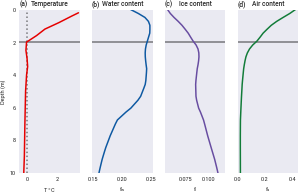

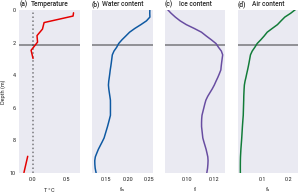

In [50]:
for bl in bl1, bl2:
    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(5, 3))
    
    for ax, s, l, b in zip(axs, short, long, "abcd"):
        ax.axhline(bl["alt"], c="k", alpha=0.5)
        ax.set_xlabel(s)
        ax.set_title(l)  
        ax.set_title("(%s)" % b, loc="left")
     
    temp = bl["temp"]

    axs[0].axvline(0, c="k", ls=":", alpha=0.5)
    axs[0].set_ylabel("Depth (m)")
    axs[0].set_ylim(10, 0)
    axs[0].set_xlim(*bl["templim"])
    
    axs[0].plot(temp[:,0], temp[:,1], "-", c=colors[0])
    
    for i, (ax, quant) in enumerate(zip(axs[1:], "wia")):
        ax.plot(*get("f" + quant, bl), "-", c=colors[i + 1]) 

    fig.savefig(bl["name"] + "_bl_logs.pdf")